In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## EFCamDat EDA

In [28]:
df = pd.read_csv("efcamdat_final.csv")

In [29]:
# n unique learner Id's
len(df['learner_id'].unique())

84696

In [30]:
df['cefr_numeric'].value_counts()

3    100506
1    100000
2    100000
4     40238
5     10006
Name: cefr_numeric, dtype: int64

In [5]:
df.columns

Index(['Unnamed: 0', 'writing_id', 'learner_id', 'learner_id_categorical',
       'nationality', 'l1', 'cefr', 'cefr_numeric', 'level', 'unit',
       'topic_id_original', 'topic_id_original_categorical', 'topic_id',
       'topic_id_categorical', 'text_number_per_learner_in_task', 'topic',
       'secondary_topic', 'topic_to_keep', 'date', 'time', 'grade',
       'wordcount', 'mtld', 'text', 'text_corrected'],
      dtype='object')

In [6]:
# n unique country ids
len(df['nationality'].unique())

11

In [7]:
# n topics
len(df['topic_id'].unique())

120

In [8]:
from transformers import RobertaTokenizer, TFRobertaModel
rtokenizer = RobertaTokenizer.from_pretrained('roberta-base')

In [9]:
tokens = rtokenizer(df['text'].tolist(), truncation=True, padding=True, max_length=500, return_tensors='tf')

Metal device set to: Apple M1 Pro


2024-07-29 12:01:26.638343: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-07-29 12:01:26.639050: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [10]:
tok_lens = np.sum(np.array(tokens['input_ids']) != 1, axis=1)

In [11]:
def tok_stats(token_lengths):
    avg_length = np.mean(token_lengths)
    median_length = np.median(token_lengths)
    max_length = np.max(token_lengths)
    min_length = np.min(token_lengths)
    
    # Return the results as a dictionary
    return {
        "average_length": avg_length,
        "median_length": median_length,
        "max_length": max_length,
        "min_length": min_length,
        "total_texts": len(token_lengths)
    }

tok_stats(tok_lens)

{'average_length': 103.7103378474697,
 'median_length': 97.0,
 'max_length': 485,
 'min_length': 27,
 'total_texts': 350750}

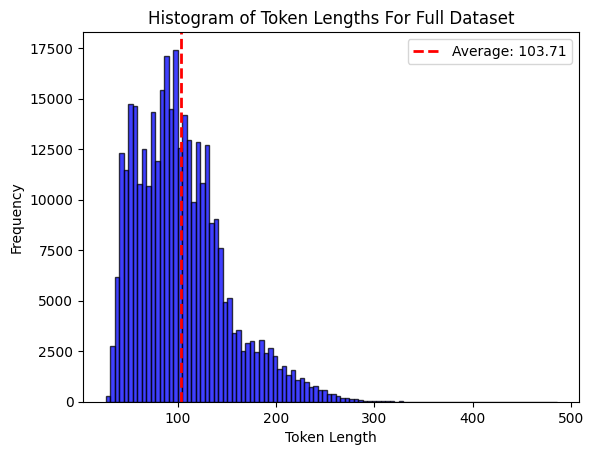

In [12]:
plt.hist(tok_lens, bins=100, alpha=0.75, color='blue', edgecolor='black')

# Draw the average line
plt.axvline(np.mean(tok_lens), color='red', linestyle='dashed', linewidth=2, label=f'Average: {np.mean(tok_lens):.2f}')

# Add labels and title
plt.xlabel('Token Length')
plt.ylabel('Frequency')
plt.title('Histogram of Token Lengths For Full Dataset')

# Add legend
plt.legend()

plt.savefig('efcamdat_full_hist.png')

In [13]:
df1 = pd.read_csv("../efcamdat_sub.csv")

In [14]:
#n unique learners
len(df1['learner_id'].unique())

110053

In [15]:
#n unique countries
len(df1['learner_nationality'].unique())

186

In [16]:
#n unique topics
len(df1['topic_id'].unique())

128

In [17]:
tokens = rtokenizer(df1['text'].tolist(), truncation=True, padding=True, max_length=500, return_tensors='tf')

In [18]:
tok_lens = np.sum(np.array(tokens['input_ids']) != 1, axis=1)

def tok_stats(token_lengths):
    avg_length = np.mean(token_lengths)
    median_length = np.median(token_lengths)
    max_length = np.max(token_lengths)
    min_length = np.min(token_lengths)
    
    # Return the results as a dictionary
    return {
        "average_length": avg_length,
        "median_length": median_length,
        "max_length": max_length,
        "min_length": min_length,
        "total_texts": len(token_lengths)
    }

tok_stats(tok_lens)

{'average_length': 115.34626038781164,
 'median_length': 107.0,
 'max_length': 500,
 'min_length': 3,
 'total_texts': 377967}

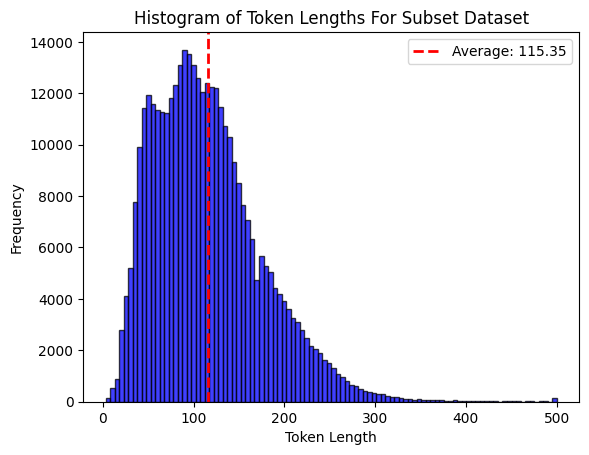

In [19]:
plt.hist(tok_lens, bins=100, alpha=0.75, color='blue', edgecolor='black')

# Draw the average line
plt.axvline(np.mean(tok_lens), color='red', linestyle='dashed', linewidth=2, label=f'Average: {np.mean(tok_lens):.2f}')

# Add labels and title
plt.xlabel('Token Length')
plt.ylabel('Frequency')
plt.title('Histogram of Token Lengths For Subset Dataset')

# Add legend
plt.legend()

plt.savefig('efcamdat_sub_hist.png')

In [20]:
df[df['topic_id'] == 100]['cefr_numeric'].value_counts()

5    440
Name: cefr_numeric, dtype: int64

In [74]:
df1['labels'] = df1['cefr_numeric'].apply(lambda x: x-1)

In [75]:
def clip_words(text, num_words=5):
    text = str(text)
    words = text.split()
    if len(words) > 2 * num_words:
        return ' '.join(words[num_words:-num_words])
    else:
        # If the text has fewer than 2 * num_words, return an empty string or handle accordingly
        return text

In [76]:
df1['text_clipped'] = df1['text'].apply(clip_words)

In [80]:
import random
from tqdm import tqdm
import nltk
from nltk.corpus import wordnet

# Download the WordNet corpus
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/danielskahill/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/danielskahill/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [81]:
from nltk.tokenize import sent_tokenize

def synonym_replacement(text):
    words = text.split()
    new_words = []
    
    for word in words:
        synonyms = wordnet.synsets(word)
        if synonyms:
            synonym = random.choice(synonyms).lemmas()[0].name()
            new_words.append(synonym if synonym != word else word)
        else:
            new_words.append(word)
    
    return ' '.join(new_words)

def random_insertion(text):
    words = text.split()
    new_words = words.copy()
    synonyms = [wordnet.synsets(word)[0].lemmas()[0].name() for word in words if wordnet.synsets(word)]
    
    num_insertions = random.randint(1, 3)
    for _ in range(num_insertions):
        insert_word = random.choice(synonyms) if synonyms else random.choice(words)
        position = random.randint(0, len(new_words))
        new_words.insert(position, insert_word)
    
    return ' '.join(new_words)

def random_deletion(text, p=0.2):
    words = text.split()
    new_words = [word for word in words if random.random() > p]
    return ' '.join(new_words) if new_words else words[0]

def sentence_shuffling(text):
    sentences = sent_tokenize(text)
    if len(sentences) < 2:
        return text
    random.shuffle(sentences)
    return ' '.join(sentences)

def augment(text):
    if random.random() > .3:
        return text
    else:
        if random.random() < .2:
            text = synonym_replacement(text)
        if random.random() < .2: 
            text = random_insertion(text)
        if random.random() < .2:
            text = random_deletion(text, p=0.2)
        if random.random() < .2: 
            text = sentence_shuffling(text)
        return text 


In [82]:
tqdm.pandas()
df1['text_clipped'] = df1['text_clipped'].progress_apply(lambda x: augment(x))


100%|███████████████████████████████████| 377967/377967 [01:00<00:00, 6295.99it/s]


In [83]:
df1['text_clipped']

0         xxx@IXW.corporation To whom it may concern. Im...
1         receive this you. Also I wish interesting cour...
2         give up of my idea. I understood the steps, br...
3         have been brought to my attention relating to ...
4         interest in our products. To 1000 pens and 100...
                                ...                        
377962    always is a difficult time. We are always bett...
377963    a presentation about sales AS force's moral. E...
377964    think that my first step was kicking a soccer ...
377965    AG takes sometime, but now, I realize what a g...
377966    meteting SP meeting to discuss some subjects a...
Name: text_clipped, Length: 377967, dtype: object

In [91]:
df.groupby('cefr_numeric')['topic_id'].nunique()

cefr_numeric
1    24
2    24
3    24
4    24
5    24
6     8
Name: topic_id, dtype: int64

In [94]:
df['labels'] = df['cefr_numeric']

In [97]:
df[df['labels'] == 1] = 0

## Looking at Responses

In [187]:
df['topic'].unique()

array(['Giving instructions to play a game', 'Planning for the future',
       'Writing a job advertisement',
       'Writing about a memorable experience',
       'Taking part in a TV viewing survey', 'Issuing a written warning',
       'Writing a letter of complaint',
       'Posting comments on a celebrity forum',
       'Writing a natural remedies pamphlet',
       'Reviewing a song for a website',
       "Making a 'to do' list of your dreams",
       'Describing a business trip', 'Selling items in an online auction',
       'Responding to written invitations',
       'Congratulating a friend on an award',
       'Claiming back your security deposit',
       'Giving feedback to a restaurant', 'Studying online',
       'Making a business proposal', 'Signing a waiver to go skydiving',
       'Writing safety guidelines', 'Asking for leave',
       'Writing an apology email', 'Writing a blog',
       'Helping a friend find a job',
       'Doing a survey about discrimination', 'Requesti

In [169]:
df.columns

Index(['Unnamed: 0', 'writing_id', 'learner_id', 'learner_id_categorical',
       'nationality', 'l1', 'cefr', 'cefr_numeric', 'level', 'unit',
       'topic_id_original', 'topic_id_original_categorical', 'topic_id',
       'topic_id_categorical', 'text_number_per_learner_in_task', 'topic',
       'secondary_topic', 'topic_to_keep', 'date', 'time', 'grade',
       'wordcount', 'mtld', 'text', 'text_corrected'],
      dtype='object')

## OneStopEnglishCorpus Stats

In [23]:
df2 = pd.read_csv("../onestopec.csv")

In [26]:
tokens = rtokenizer([str(x) for x in df2['text'].tolist()], truncation=True, padding=True, max_length=500, return_tensors='tf')

In [27]:
tok_lens = np.sum(np.array(tokens['input_ids']) != 1, axis=1)

def tok_stats(token_lengths):
    avg_length = np.mean(token_lengths)
    median_length = np.median(token_lengths)
    max_length = np.max(token_lengths)
    min_length = np.min(token_lengths)
    
    # Return the results as a dictionary
    return {
        "average_length": avg_length,
        "median_length": median_length,
        "max_length": max_length,
        "min_length": min_length,
        "total_texts": len(token_lengths)
    }

tok_stats(tok_lens)

{'average_length': 74.5172367175882,
 'median_length': 68.0,
 'max_length': 416,
 'min_length': 3,
 'total_texts': 7397}

In [36]:
df2['labels'].value_counts()

3    2651
2    2595
1    2151
Name: labels, dtype: int64

In [32]:
df3 = pd.read_csv("../efcamdat_sub.csv")

In [33]:
df3['cefr_numeric'].value_counts()

3    100000
2    100000
1    100000
4     61329
5     14698
6      1940
Name: cefr_numeric, dtype: int64